In [18]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations
from multiprocessing import Pool

In [19]:
import sys
sys.path.append('..')

from util.participant_stream import ParticipantStream

In [3]:
# list of seeds to average over
seeds = np.random.randint(1000, 9999, 100)

In [20]:
def generate_theoretical_pdf(rng: np.random.Generator):
    def continuous_uniform_range_pair(lower_bound, upper_bound, num_samples):
        samples = rng.uniform(lower_bound, upper_bound, (2, num_samples))
        for i in range(num_samples):
            while samples[0,i] == samples[1,i]:
                samples[0,i] = rng.uniform(lower_bound, upper_bound)
                samples[1,i] = rng.uniform(lower_bound, upper_bound)
            if samples[0,i] > samples[1, i]:
                samples[0,i], samples[1,i] = samples[1,i], samples[0,i]
        return samples
    
    def generate_hist2d_pdf(hist, x_edges, y_edges):
        def sample_pdf(x, y):
            x_bin = np.argmax(np.where((np.expand_dims(x_edges, axis=1) < x).transpose(), x_edges, 0), axis=1)
            y_bin = np.argmax(np.where((np.expand_dims(y_edges, axis=1) < y).transpose(), y_edges, 0), axis=1)
            return hist[x_bin, y_bin]
        return sample_pdf
    
    theory_num_samples = 50000
    theory_samples = continuous_uniform_range_pair(19, 80, theory_num_samples)
    bins = 60
    t_hist, t_younger_edges, t_older_edges = np.histogram2d(theory_samples[0], theory_samples[1], bins=bins, range=[[19,80],[19,80]], density=True)
    age_pdf = generate_hist2d_pdf(t_hist, t_younger_edges, t_older_edges)
    return age_pdf

In [21]:
def simulate_algo_1(rng, age_pdf, plot_simulation=False):
    stream = ParticipantStream(rng=rng)
    datapoints = None
    data_kde = None
    batches = 0
    scores = {"linear": [], "squared": []}

    def generate_batch(n):
        return stream.generate_participants(n)
    
    def add_batch(samples: np.ndarray):
        # assuming samples come in the form of [[p1, p2], [p1, p2], ...]
        nonlocal datapoints, data_kde, batches
        if datapoints is not None:
            datapoints = np.hstack([datapoints, samples.transpose()])
        else:
            datapoints = np.copy(samples.transpose())
        data_kde = stats.gaussian_kde(datapoints)
        batches += 1
    
    def global_pdf(samples: np.ndarray):
        nonlocal datapoints, data_kde
        if datapoints is not None:
            return data_kde(samples)
        return np.zeros(samples.shape[1])
    
    def run_batch():
        pool = generate_batch(100)
        # extract age feature from participant metadata
        ages = np.fromiter((p['age'] for p in pool), dtype=int)
        # sample possible pairs to build kde
        sampled_pairs = rng.choice(ages, (2, 10000))
        sample_pdf = stats.gaussian_kde(sampled_pairs)
        # get all possible pairings given pool
        all_pairs = np.array(list(combinations(ages, 2)))
        # compute probability of the pairings occuring, adjusted by what's already in batch
        all_pairs_prob = sample_pdf(all_pairs.transpose()) + global_pdf(all_pairs.transpose())
        # sort all pairs from lowest probability to highest probability
        best_pairs = np.take(all_pairs, np.argsort(all_pairs_prob), axis=0)
        # Greedily pick pairs to sample
        age_map = {}
        for p in pool:
            if p['age'] not in age_map:
                age_map[p['age']] = [p]
            else:
                age_map[p['age']].append(p)
        grouping = []
        age_grouping = []
        for pair in all_pairs:
            p1 = int(pair[0])
            p2 = int(pair[1])
            if p1 > p2:
                p1, p2 = p2, p1
            if p1 not in age_map or p2 not in age_map:
                continue
            if p1 == p2 and len(age_map[p1]) < 2:
                continue
            grouping.append((age_map[p1].pop(), age_map[p2].pop()))
            age_grouping.append([p1, p2])
            if len(age_map[p1]) == 0:
                del age_map[p1]
            if p2 != p1 and len(age_map[p2]) == 0:
                del age_map[p2]
            if not age_map:
                break
        # update sampled dataset
        add_batch(np.array(age_grouping))
    
    def evaluate_dataset(plot=False):
        x_coords, y_coords = np.mgrid[19:80, 19:80]
        pos = np.vstack([x_coords.ravel(), y_coords.ravel()])
        
        z = np.reshape(data_kde(pos).T, x_coords.shape)
        dif = np.reshape((age_pdf(pos[0], pos[1]) - data_kde(pos)).T, x_coords.shape)
        
        if plot:
            fig, axes = plt.subplots(4, 1, figsize=(6, 20))

            a0 = axes[0].imshow(z.T, origin='lower', extent=[19, 80, 19, 80])
            fig.colorbar(a0, ax=axes[0], label='Frequency')
            axes[0].set_title('Frequency Surface of Age Pair Sampled KDE')
            axes[0].set_xlabel('Younger Age')
            axes[0].set_ylabel('Older Age')
            axes[0].grid(True)
            
            cmap_max = np.max(np.abs(dif))
            a1 = axes[1].imshow(dif.T, origin='lower', extent=[19, 80, 19, 80], cmap="bwr", vmin=-cmap_max, vmax=cmap_max)
            fig.colorbar(a1, ax=axes[1], label='Difference')
            axes[1].set_title('Difference in Frequency Surface of Age Pair Sampled KDE and Theoretical PDF', wrap=True)
            axes[1].set_xlabel('Younger Age')
            axes[1].set_ylabel('Older Age')
            axes[1].grid(True)

            a2 = axes[2].imshow(np.abs(dif).T, origin='lower', extent=[19, 80, 19, 80])
            fig.colorbar(a2, ax=axes[2], label='Absolute Difference')
            axes[2].set_title('Absolute Difference in Frequency Surface of Age Pair Sampled KDE and Theoretical PDF', wrap=True)
            axes[2].set_xlabel('Younger Age')
            axes[2].set_ylabel('Older Age')
            axes[2].grid(True)

            a3 = axes[3].imshow(np.abs(dif ** 2).T, origin='lower', extent=[19, 80, 19, 80])
            fig.colorbar(a3, ax=axes[3], label='Absolute Squared Difference')
            axes[3].set_title('Absolute Squared Difference in Frequency Surface of Age Pair Sampled KDE and Theoretical PDF', pad=20, wrap=True)
            axes[3].set_xlabel('Younger Age')
            axes[3].set_ylabel('Older Age')
            axes[3].grid(True)   

            fig.tight_layout()

        return {"linear": np.sum(np.triu(np.abs(dif))), "squared": np.sum(np.triu(np.abs(dif ** 2)))}
    
    for i in range(100):
        run_batch()
        res = evaluate_dataset()
        scores["linear"].append(res['linear'])
        scores["squared"].append(res['squared'])
    evaluate_dataset(plot=plot_simulation)
    return scores

In [28]:
def simulate_baseline(rng, age_pdf, plot_simulation=False):
    b_stream = ParticipantStream(rng=rng)
    b_samples = None
    b_kde = None
    b_scores = {'linear': [], 'squared': []}

    def run_baseline_batch(size):
        nonlocal b_samples, b_kde
        size = size >> 1 << 1
        b_pool = b_stream.generate_participants(size)
        bs = np.zeros((2, size >> 1))
        for i in range(0, len(b_pool), 2):
            if b_pool[i]['age'] < b_pool[i+1]['age']:
                bs[0,i//2] = b_pool[i]['age']
                bs[1,i//2] = b_pool[i+1]['age']
            else:
                bs[0,i//2] = b_pool[i+1]['age']
                bs[1,i//2] = b_pool[i]['age']
        if b_samples is not None:
            b_samples = np.hstack([b_samples, bs])
        else:
            b_samples = bs
        b_kde = stats.gaussian_kde(b_samples)
    
    def evaluate_baseline_batch(plot = False):
        b_x_coords, b_y_coords = np.mgrid[19:80, 19:80]
        b_pos = np.vstack([b_x_coords.ravel(), b_y_coords.ravel()])
        b_z = np.reshape(b_kde(b_pos).T, b_x_coords.shape)
        b_dif = np.reshape((age_pdf(b_pos[0], b_pos[1]) - b_kde(b_pos)).T, b_x_coords.shape)

        if plot:
            fig, axes = plt.subplots(4, 1, figsize=(6, 20))

            a0 = axes[0].imshow(b_z.T, origin='lower', extent=[19, 80, 19, 80])
            fig.colorbar(a0, ax=axes[0], label='Frequency')
            axes[0].set_title('Frequency Surface of Age Pair Sampled KDE')
            axes[0].set_xlabel('Younger Age')
            axes[0].set_ylabel('Older Age')
            axes[0].grid(True)

            cmap_max = np.max(np.abs(b_dif))
            a1 = axes[1].imshow(b_dif.T, origin='lower', extent=[19, 80, 19, 80], cmap="bwr", vmin=-cmap_max, vmax=cmap_max)
            fig.colorbar(a1, ax=axes[1], label='Difference')
            axes[1].set_title('Difference in Frequency Surface of Age Pair Sampled KDE and Theoretical PDF', wrap=True)
            axes[1].set_xlabel('Younger Age')
            axes[1].set_ylabel('Older Age')
            axes[1].grid(True)

            a2 = axes[2].imshow(np.abs(b_dif).T, origin='lower', extent=[19, 80, 19, 80])
            fig.colorbar(a2, ax=axes[2], label='Absolute Difference')
            axes[2].set_title('Absolute Difference in Frequency Surface of Age Pair Sampled KDE and Theoretical PDF', wrap=True)
            axes[2].set_xlabel('Younger Age')
            axes[2].set_ylabel('Older Age')
            axes[2].grid(True)

            a3 = axes[3].imshow(np.abs(b_dif ** 2).T, origin='lower', extent=[19, 80, 19, 80])
            fig.colorbar(a3, ax=axes[3], label='Absolute Squared Difference')
            axes[3].set_title('Absolute Squared Difference in Frequency Surface of Age Pair Sampled KDE and Theoretical PDF', pad=20, wrap=True)
            axes[3].set_xlabel('Younger Age')
            axes[3].set_ylabel('Older Age')
            axes[3].grid(True)   

            fig.tight_layout()

        return {"linear": np.sum(np.triu(np.abs(b_dif))), "squared": np.sum(np.triu(np.abs(b_dif ** 2)))}
    
    # batch 100
    for i in range(100):
        run_baseline_batch(100)
        res = evaluate_baseline_batch()
        b_scores['linear'].append(res['linear'])
        b_scores['squared'].append(res['squared'])
    evaluate_baseline_batch(plot=plot_simulation)
    return b_scores

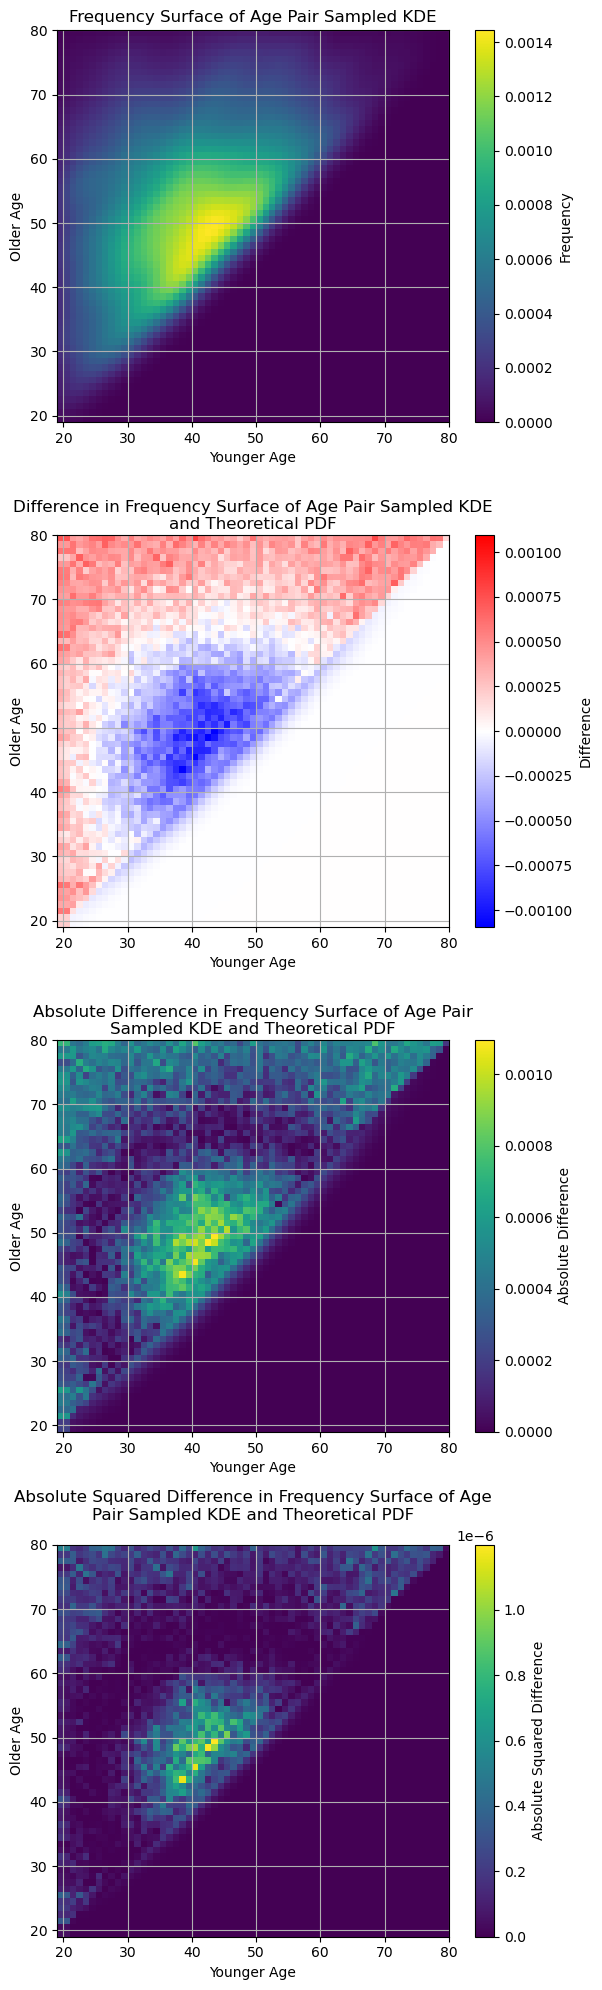

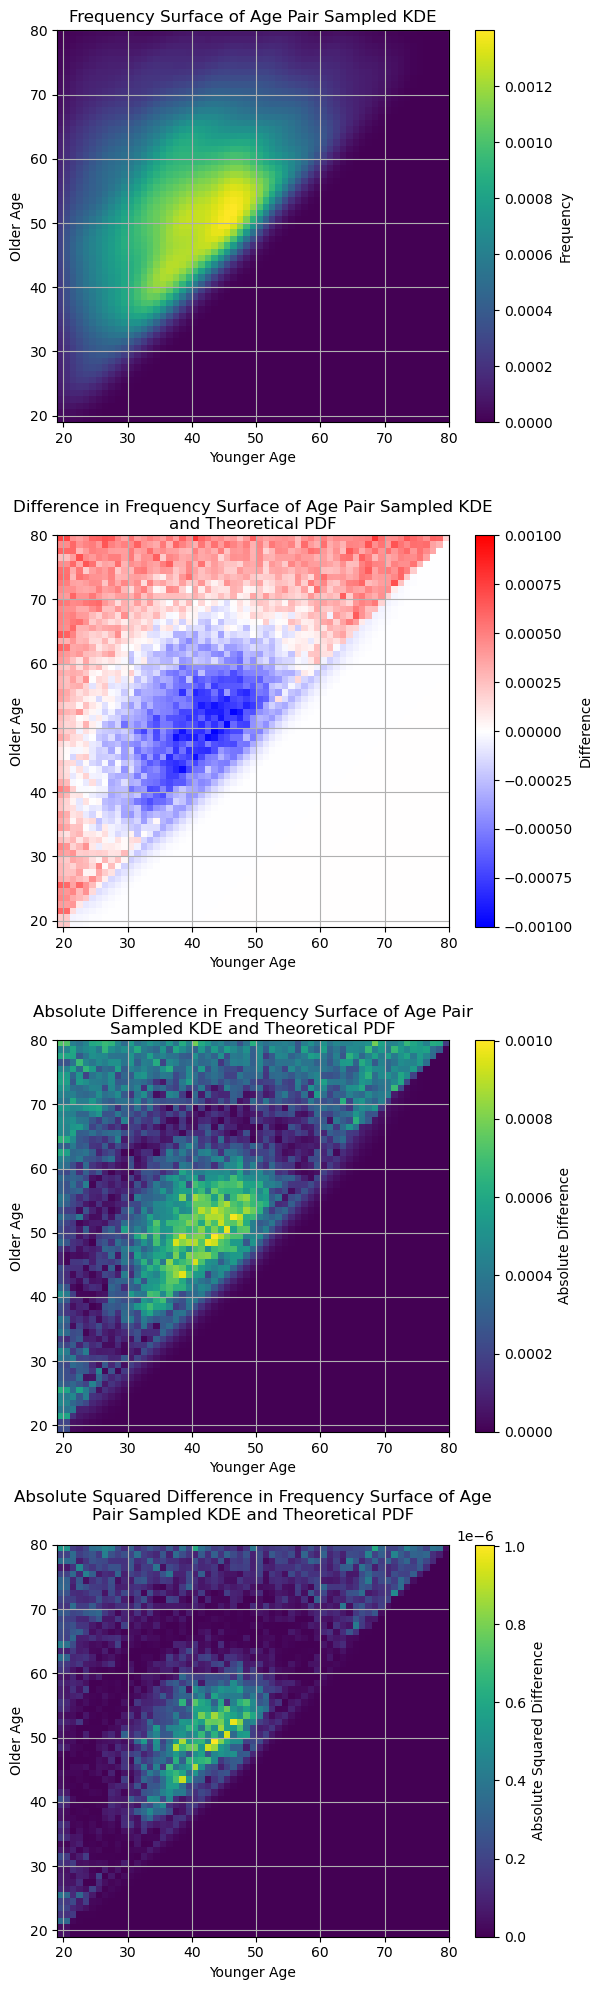

In [7]:
# Proof of Concept Test
rng = np.random.default_rng(seed=4399)
age_pdf = generate_theoretical_pdf(rng)
algo_1_scores = simulate_algo_1(rng, age_pdf, True)
baseline_scores = simulate_baseline(rng, age_pdf, True)

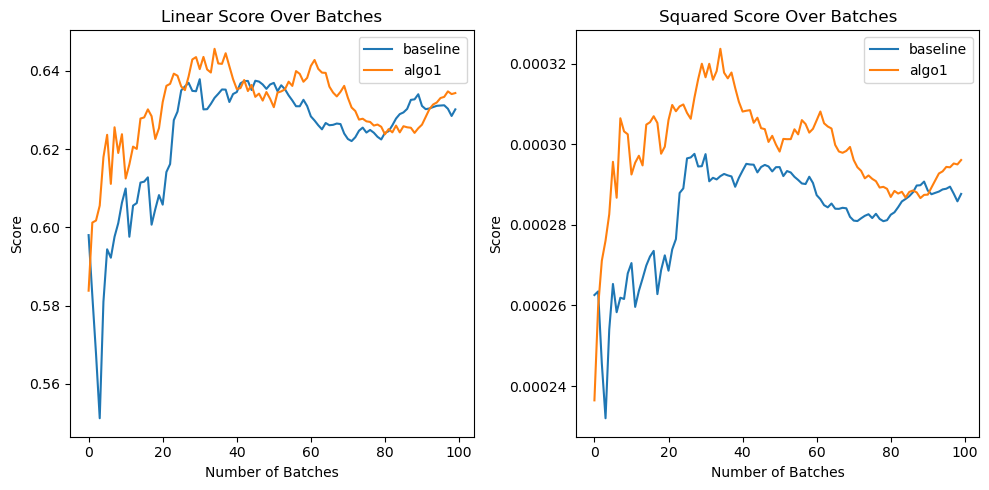

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(baseline_scores['linear'], label='baseline')
ax[0].plot(algo_1_scores['linear'], label='algo1')
ax[0].set_title("Linear Score Over Batches")
ax[0].set_xlabel('Number of Batches')
ax[0].set_ylabel('Score')
ax[0].legend()

ax[1].plot(baseline_scores['squared'], label='baseline')
ax[1].plot(algo_1_scores['squared'], label='algo1')
ax[1].set_title("Squared Score Over Batches")
ax[1].set_xlabel('Number of Batches')
ax[1].set_ylabel('Score')
ax[1].legend()
fig.tight_layout()


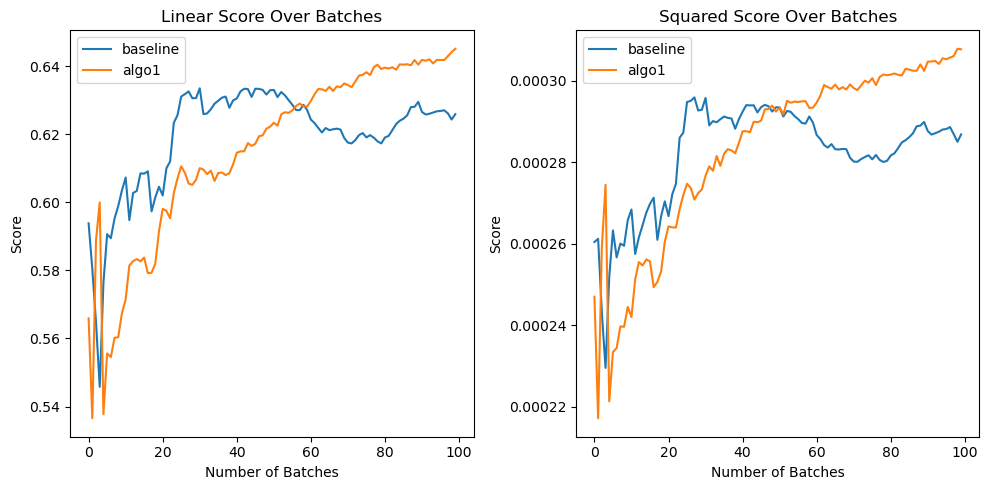

In [23]:
# Proof of Concept Test
rng = np.random.default_rng(seed=13245709)
age_pdf = generate_theoretical_pdf(rng)
algo_1_scores = simulate_algo_1(rng, age_pdf, False)
baseline_scores = simulate_baseline(rng, age_pdf, False)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(baseline_scores['linear'], label='baseline')
ax[0].plot(algo_1_scores['linear'], label='algo1')
ax[0].set_title("Linear Score Over Batches")
ax[0].set_xlabel('Number of Batches')
ax[0].set_ylabel('Score')
ax[0].legend()

ax[1].plot(baseline_scores['squared'], label='baseline')
ax[1].plot(algo_1_scores['squared'], label='algo1')
ax[1].set_title("Squared Score Over Batches")
ax[1].set_xlabel('Number of Batches')
ax[1].set_ylabel('Score')
ax[1].legend()
fig.tight_layout()

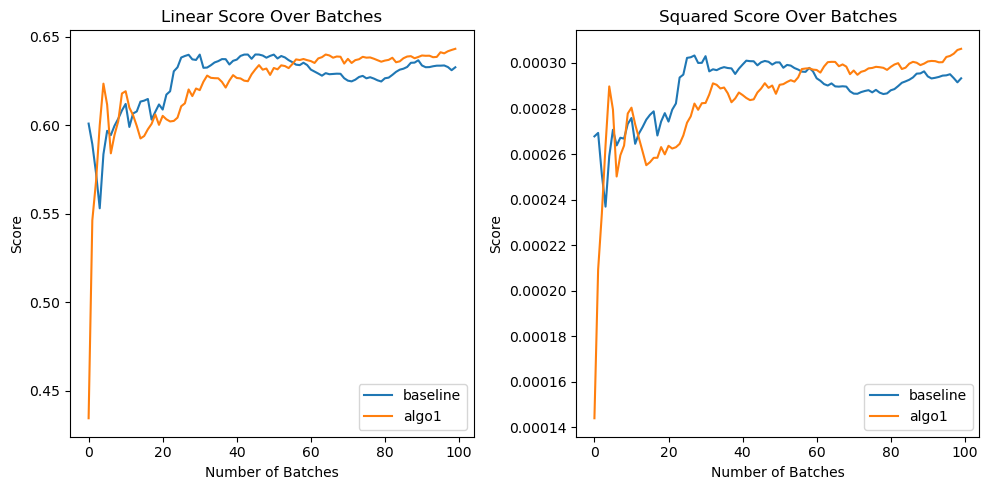

In [24]:
# Proof of Concept Test
rng = np.random.default_rng(seed=543127890)
age_pdf = generate_theoretical_pdf(rng)
algo_1_scores = simulate_algo_1(rng, age_pdf, False)
baseline_scores = simulate_baseline(rng, age_pdf, False)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(baseline_scores['linear'], label='baseline')
ax[0].plot(algo_1_scores['linear'], label='algo1')
ax[0].set_title("Linear Score Over Batches")
ax[0].set_xlabel('Number of Batches')
ax[0].set_ylabel('Score')
ax[0].legend()

ax[1].plot(baseline_scores['squared'], label='baseline')
ax[1].plot(algo_1_scores['squared'], label='algo1')
ax[1].set_title("Squared Score Over Batches")
ax[1].set_xlabel('Number of Batches')
ax[1].set_ylabel('Score')
ax[1].legend()
fig.tight_layout()

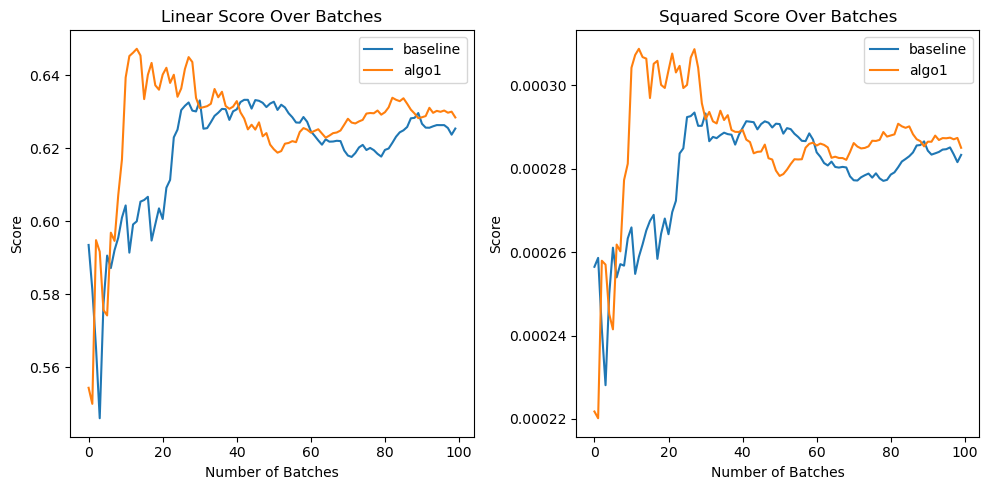

In [25]:
# Proof of Concept Test
rng = np.random.default_rng(seed=314705)
age_pdf = generate_theoretical_pdf(rng)
algo_1_scores = simulate_algo_1(rng, age_pdf, False)
baseline_scores = simulate_baseline(rng, age_pdf, False)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(baseline_scores['linear'], label='baseline')
ax[0].plot(algo_1_scores['linear'], label='algo1')
ax[0].set_title("Linear Score Over Batches")
ax[0].set_xlabel('Number of Batches')
ax[0].set_ylabel('Score')
ax[0].legend()

ax[1].plot(baseline_scores['squared'], label='baseline')
ax[1].plot(algo_1_scores['squared'], label='algo1')
ax[1].set_title("Squared Score Over Batches")
ax[1].set_xlabel('Number of Batches')
ax[1].set_ylabel('Score')
ax[1].legend()
fig.tight_layout()

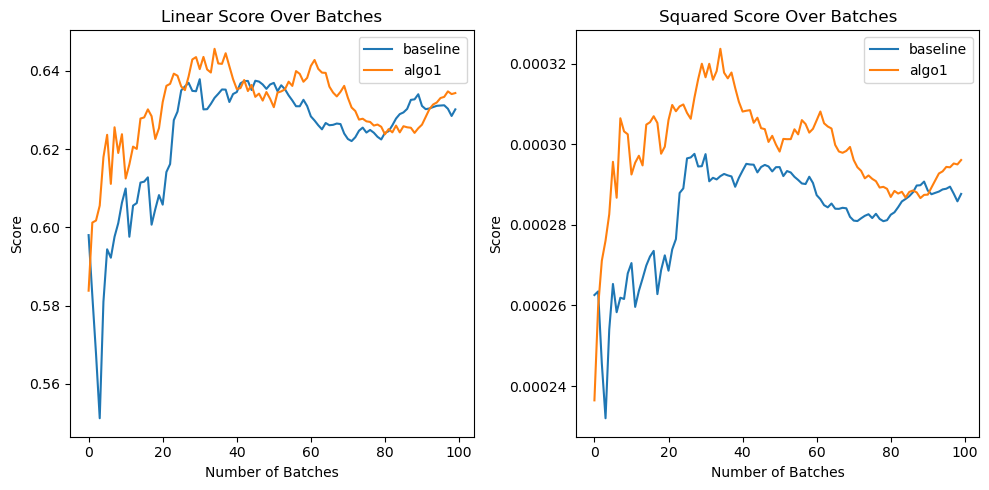

In [26]:
# Proof of Concept Test
rng = np.random.default_rng(seed=4327801)
age_pdf = generate_theoretical_pdf(rng)
algo_1_scores = simulate_algo_1(rng, age_pdf, False)
baseline_scores = simulate_baseline(rng, age_pdf, False)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(baseline_scores['linear'], label='baseline')
ax[0].plot(algo_1_scores['linear'], label='algo1')
ax[0].set_title("Linear Score Over Batches")
ax[0].set_xlabel('Number of Batches')
ax[0].set_ylabel('Score')
ax[0].legend()

ax[1].plot(baseline_scores['squared'], label='baseline')
ax[1].plot(algo_1_scores['squared'], label='algo1')
ax[1].set_title("Squared Score Over Batches")
ax[1].set_xlabel('Number of Batches')
ax[1].set_ylabel('Score')
ax[1].legend()
fig.tight_layout()

In [9]:
baseline_scores = {'linear': np.empty((100, 100)), 'squared': np.empty((100, 100))}
algo_1_scores = {'linear': np.empty((100, 100)), 'squared': np.empty((100, 100))}

In [10]:
def simulate_once(seed_num):
    rng = np.random.default_rng(seed=seed_num)
    age_pdf = generate_theoretical_pdf(rng)
    a1s = simulate_algo_1(rng, age_pdf, False)
    bs = simulate_baseline(rng, age_pdf, False)
    return (a1s, bs)

In [12]:
score_file = np.load("../simulation_scores_2023-11-27_19-12-06.npz")
baseline_scores = {'linear': score_file['baseline_linear'], 'squared': score_file['baseline_squared']}
algo_1_scores = {'linear': score_file['algo1_linear'], 'squared': score_file['algo1_squared']}

In [13]:
algo_1_scores['linear']

array([[0.81331713, 0.74995025, 0.67926322, ..., 0.64164787, 0.64387494,
        0.64273661],
       [0.77360381, 0.63881022, 0.62302331, ..., 0.63123464, 0.63168377,
        0.6323369 ],
       [0.56836547, 0.5912305 , 0.56635527, ..., 0.62035296, 0.62053436,
        0.61872277],
       ...,
       [0.63546419, 0.56719572, 0.55399079, ..., 0.6322535 , 0.6342392 ,
        0.63375492],
       [0.49590532, 0.49478049, 0.4850326 , ..., 0.61765332, 0.61633078,
        0.6150329 ],
       [0.61231023, 0.66014304, 0.68861666, ..., 0.62447288, 0.62622804,
        0.6247452 ]])

In [12]:
for i, seed_num in enumerate([12345643, 4351613544105, 265478109, 234587091, 23458901]):
    if i >= algo_1_scores['linear'].shape[0]:
        break
    rng = np.random.default_rng(seed=seed_num)
    age_pdf = generate_theoretical_pdf(rng)
    a1s = simulate_algo_1(rng, age_pdf, False)
    algo_1_scores['linear'][i] = a1s['linear']
    algo_1_scores['squared'][i] = a1s['squared']
    bs = simulate_baseline(rng, age_pdf, False)
    baseline_scores['linear'][i] = bs['linear']
    baseline_scores['squared'][i] = bs['squared']

In [14]:
avg_algo_1_scores = {'linear': np.mean(algo_1_scores['linear'], axis=0), 
                     'squared': np.mean(algo_1_scores['squared'], axis=0)}
avg_baseline_scores = {'linear': np.mean(baseline_scores['linear'], axis=0), 
                       'squared': np.mean(baseline_scores['squared'], axis=0)}
std_algo_1_scores = {'linear': np.std(algo_1_scores['linear'], axis=0), 
                     'squared': np.std(algo_1_scores['squared'], axis=0)}
std_baseline_scores = {'linear': np.std(baseline_scores['linear'], axis=0), 
                       'squared': np.std(baseline_scores['squared'], axis=0)}
ci_algo_1_scores = {'linear': (1.96 * std_algo_1_scores['linear'] / np.sqrt(algo_1_scores['linear'].shape[0])), 
                    'squared': (1.96 * std_algo_1_scores['squared'] / np.sqrt(algo_1_scores['squared'].shape[0]))}
ci_baseline_scores = {'linear': (1.96 * std_baseline_scores['linear'] / np.sqrt(baseline_scores['linear'].shape[0])), 
                      'squared': (1.96 * std_baseline_scores['squared'] / np.sqrt(baseline_scores['squared'].shape[0]))}

In [15]:
algo_1_scores['linear'].shape

(100, 100)

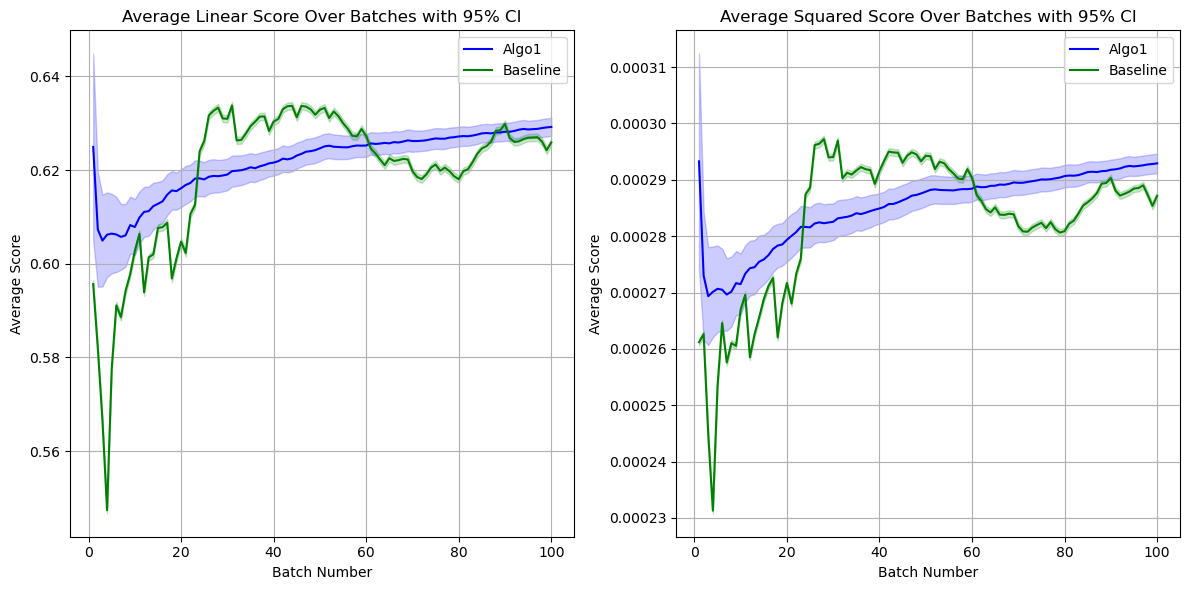

In [17]:
batches = np.arange(1,101)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(batches, avg_algo_1_scores['linear'], label="Algo1", color='blue')
ax[0].fill_between(batches, (avg_algo_1_scores['linear'] - ci_algo_1_scores['linear']), (avg_algo_1_scores['linear'] + ci_algo_1_scores['linear']), color='blue', alpha=0.2)
ax[0].plot(batches, avg_baseline_scores['linear'], label="Baseline", color='green')
ax[0].fill_between(batches, (avg_baseline_scores['linear'] - ci_baseline_scores['linear']), (avg_baseline_scores['linear'] + ci_baseline_scores['linear']), color='green', alpha=0.2)
ax[0].set_title('Average Linear Penalty Over Batches with 95% CI')
ax[0].set_xlabel('Batch Number')
ax[0].set_ylabel('Average Score')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(batches, avg_algo_1_scores['squared'], label="Algo1", color='blue')
ax[1].fill_between(batches, (avg_algo_1_scores['squared'] - ci_algo_1_scores['squared']), (avg_algo_1_scores['squared'] + ci_algo_1_scores['squared']), color='blue', alpha=0.2)
ax[1].plot(batches, avg_baseline_scores['squared'], label="Baseline", color='green')
ax[1].fill_between(batches, (avg_baseline_scores['squared'] - ci_baseline_scores['squared']), (avg_baseline_scores['squared'] + ci_baseline_scores['squared']), color='green', alpha=0.2)
ax[1].set_title('Average Squared Penalty Over Batches with 95% CI')
ax[1].set_xlabel('Batch Number')
ax[1].set_ylabel('Average Score')
ax[1].legend()
ax[1].grid(True)

fig.tight_layout()